In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gggenes)
library(ggtree)
library(Biostrings)
library(msa)
library(ape)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


ggtree v3.14.0 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

Shuangbin Xu, Lin Li, Xiao Luo, Meijun Chen, Wenli Tang, Li Zhan, Zehan
Dai, Tommy T. Lam, Yi Guan, Guangchuang Yu. Ggtree: A serialized data
object for visualization of a phylogenetic tree and annotation data.
iMeta 2022, 1(4):e56. doi:10.1002/imt2.56


Attaching package: ‘ggtree’


The following object is masked from ‘package:tidyr’:

    expand


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data

In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./bin/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/hmm_utils.R')
source('bin/utils.R')

In [4]:
# Define variables

in_training <- 'analysis/training_features.Rds'
imgvr <- list(
    'path' = '../data_copied-from-HCS/genome_databases/IMG_VR_2022-12-19_7/'
)
imgvr$proteins <- paste0(imgvr$path, 'IMGVR_all_proteins.faa')
imgvr$host_data <- paste0(imgvr$path, 'IMGVR_all_Host_information.tsv')
imgvr$seq_data <- paste0(imgvr$path, 'IMGVR_all_Sequence_information.tsv')

## Output files
out_path <- 'analysis/prediction/IMGVR/'
dir.create(out_path)

Warning message in dir.create(out_path):
“'analysis/prediction/IMGVR' already exists”


In [5]:
# Read data
data <- readRDS(in_training)
cols <- attr(data, 'colors')

In [6]:
# Read IMGVR data
imgvr_host <- readr::read_tsv(imgvr$host_data)
imgvr_seqs <- readr::read_tsv(imgvr$seq_data)

Rows: 15677623 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): UVIG, Prediction method, Host taxonomy prediction

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 15677623 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): UVIG, Scaffold_oid, Coordinates ('whole' if the UViG is the entire...
dbl  (5): Taxon_oid, Length, geNomad score, Estimated completeness, Estimate...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
dim(imgvr_seqs)
head(imgvr_seqs)

[1] 15677623       19

UVIG,Taxon_oid,Scaffold_oid,Coordinates ('whole' if the UViG is the entire contig),Ecosystem classification,vOTU,Length,Topology,geNomad score,Confidence,Estimated completeness,Estimated contamination,MIUViG quality,Gene content (total genes;cds;tRNA;geNomad marker),Taxonomic classification,Taxonomic classification method,Host taxonomy prediction,Host prediction method,Sequence origin (doi)
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
IMGVR_UViG_2504643025_000001,2504643025,2504645545,381-5974,;;;,vOTU_00000001,5594,Provirus,0.9261,High-confidence,92.20,0,High-quality,10;10;0;5,r__Monodnaviria;k__Loebvirae;p__Hofneiviricota;c__Faserviricetes;o__Tubulavirales;;;,geNomad,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter baumannii,Isolate taxonomy,Inoviruses (10.1038/s41564-019-0510-x)
IMGVR_UViG_2504756089_000001,2504756089,2504826429,1745-11143,;;;,vOTU_00000002,9399,Provirus,0.6056,High-confidence,100.00,0,High-quality,16;16;0;5,r__Monodnaviria;k__Loebvirae;p__Hofneiviricota;c__Faserviricetes;o__Tubulavirales;f__Inoviridae;;,geNomad,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella enterica,Isolate taxonomy,Inoviruses (10.1038/s41564-019-0510-x)
IMGVR_UViG_2505313053_000001,2505313053,2505349123,1-7645,Host-associated;Plants;Phyllosphere;Leaf,vOTU_00000003,7645,Provirus,0.9234,High-confidence,100.00,0,High-quality,8;8;0;6,r__Monodnaviria;k__Loebvirae;p__Hofneiviricota;c__Faserviricetes;o__Tubulavirales;f__Inoviridae;;,geNomad,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E amygdali,Isolate taxonomy,Inoviruses (10.1038/s41564-019-0510-x)
IMGVR_UViG_2506210030_000001,2506210030,2506226343,whole,Host-associated;Unclassified;Unclassified;Unclassified,vOTU_00000004,10205,Linear,0.8570,High-confidence,100.00,0,High-quality,12;12;0;7,r__Monodnaviria;k__Loebvirae;p__Hofneiviricota;c__Faserviricetes;o__Tubulavirales;f__Inoviridae;;,geNomad,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E crudilactis,Isolate taxonomy,Inoviruses (10.1038/s41564-019-0510-x)
IMGVR_UViG_2507262023_000001,2507262023,2507275142,whole,Host-associated;Human;Respiratory system;Unclassified,vOTU_00000005,7392,Linear,0.9524,High-confidence,100.00,0,High-quality,10;10;0;8,r__Monodnaviria;k__Loebvirae;p__Hofneiviricota;c__Faserviricetes;o__Tubulavirales;f__Inoviridae;;,geNomad,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas aeruginosa,Isolate taxonomy,Inoviruses (10.1038/s41564-019-0510-x)
IMGVR_UViG_2507262024_000001,2507262024,2507276053,4006-13263,Host-associated;Unclassified;Unclassified;Unclassified,vOTU_00000006,9258,Provirus,0.9471,High-confidence,86.73,0,Genome fragment,11;11;0;8,r__Monodnaviria;k__Loebvirae;p__Hofneiviricota;c__Faserviricetes;o__Tubulavirales;f__Inoviridae;;,geNomad,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas aeruginosa,Isolate taxonomy,Inoviruses (10.1038/s41564-019-0510-x)


In [8]:
# What is overlapping between INPHARED and IMGVR

Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


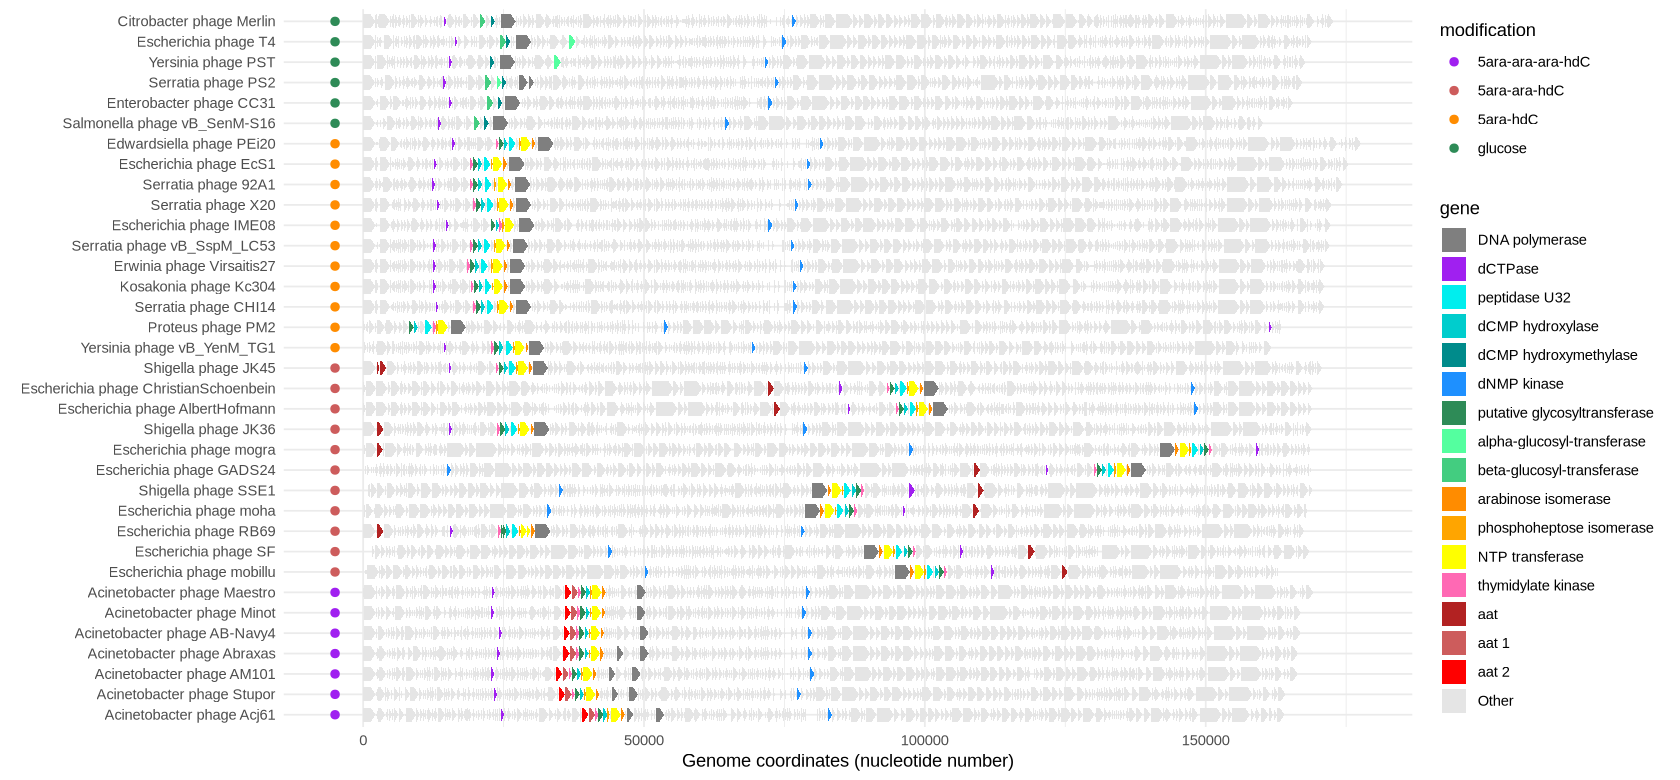

In [9]:
# Visualize genomes
options(repr.plot.width=14, repr.plot.height=6.5)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA,
                    arrowhead_height = unit(3, "mm"), arrowhead_width = unit(1, "mm")
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$known_modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification), size=2) +
    theme_minimal(11) +
    guides(fill = guide_legend(position = 'right', nrow=17), 
           col = guide_legend(position = 'right', nrow=4)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')
fn <- paste0(out_path,'genome-tracks_training-annotation','.png')
ggsave(fn, width = 14, height = 6.5, bg='white')

use default substitution matrix
use default substitution matrix


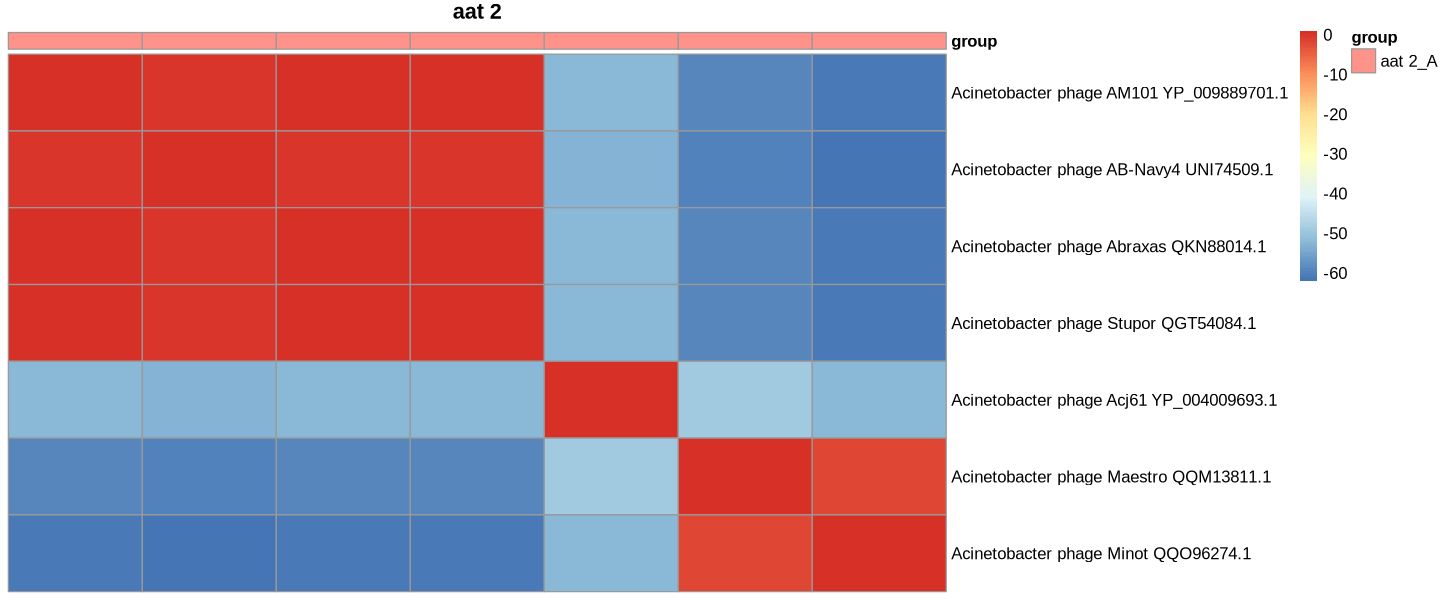

use default substitution matrix


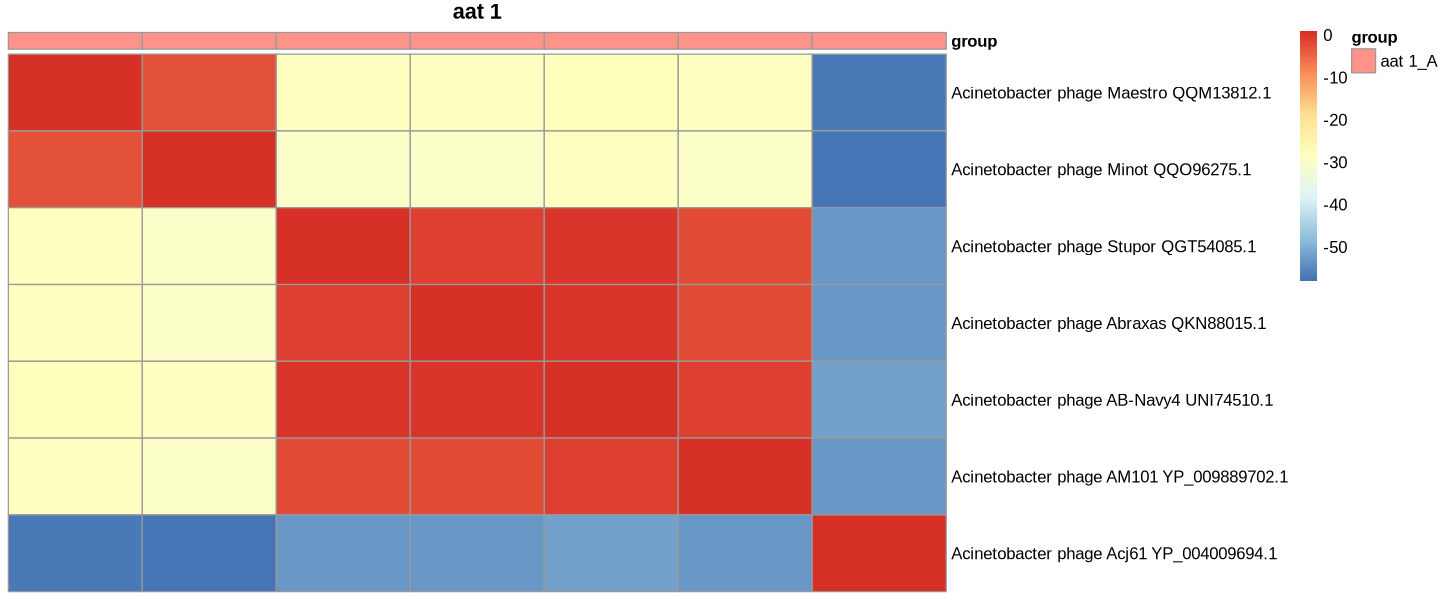

use default substitution matrix


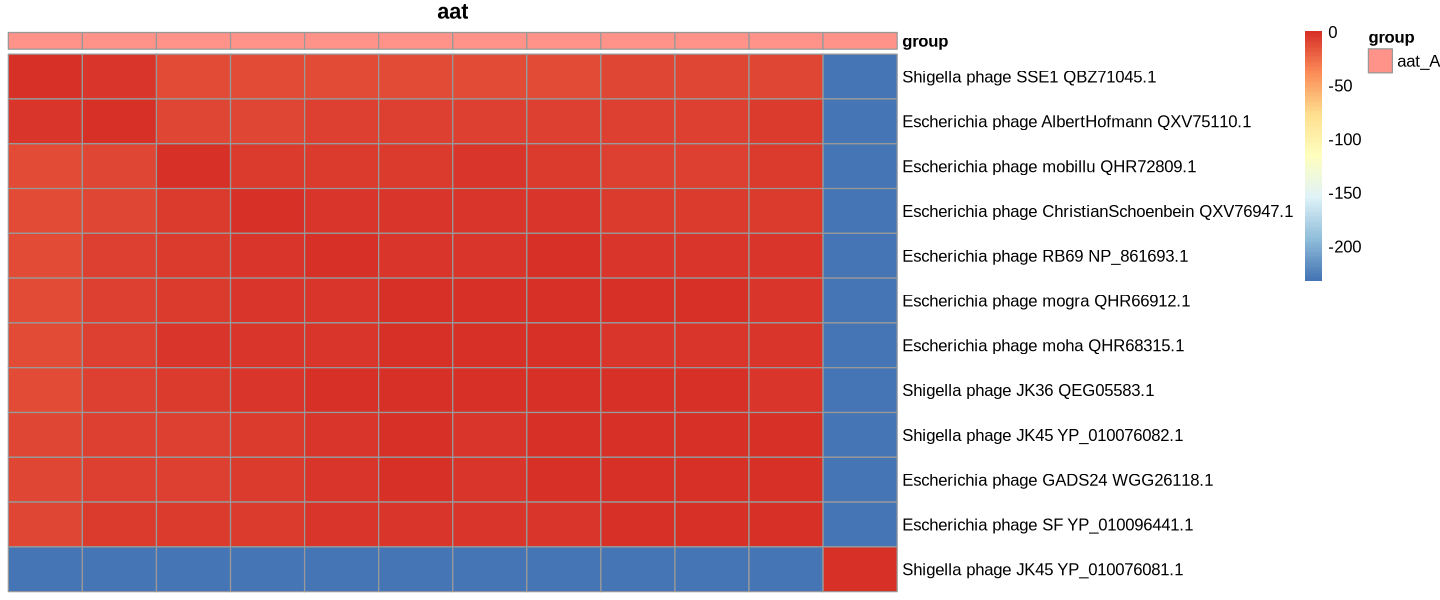

use default substitution matrix


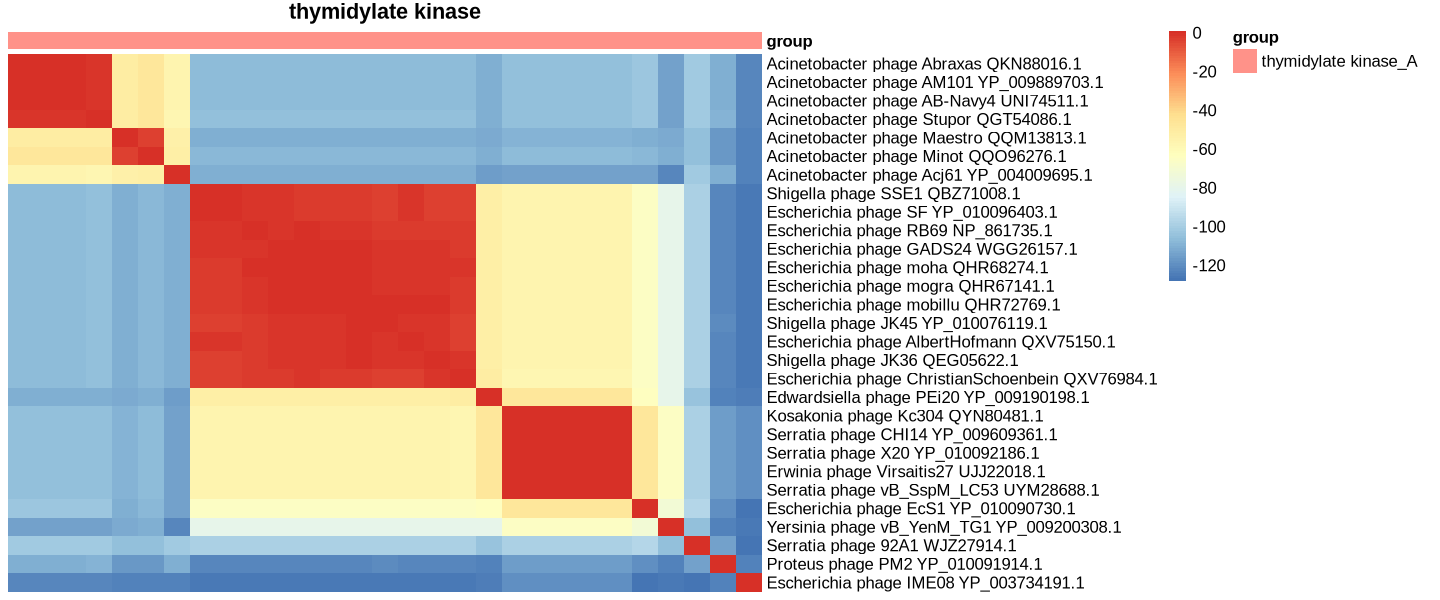

use default substitution matrix


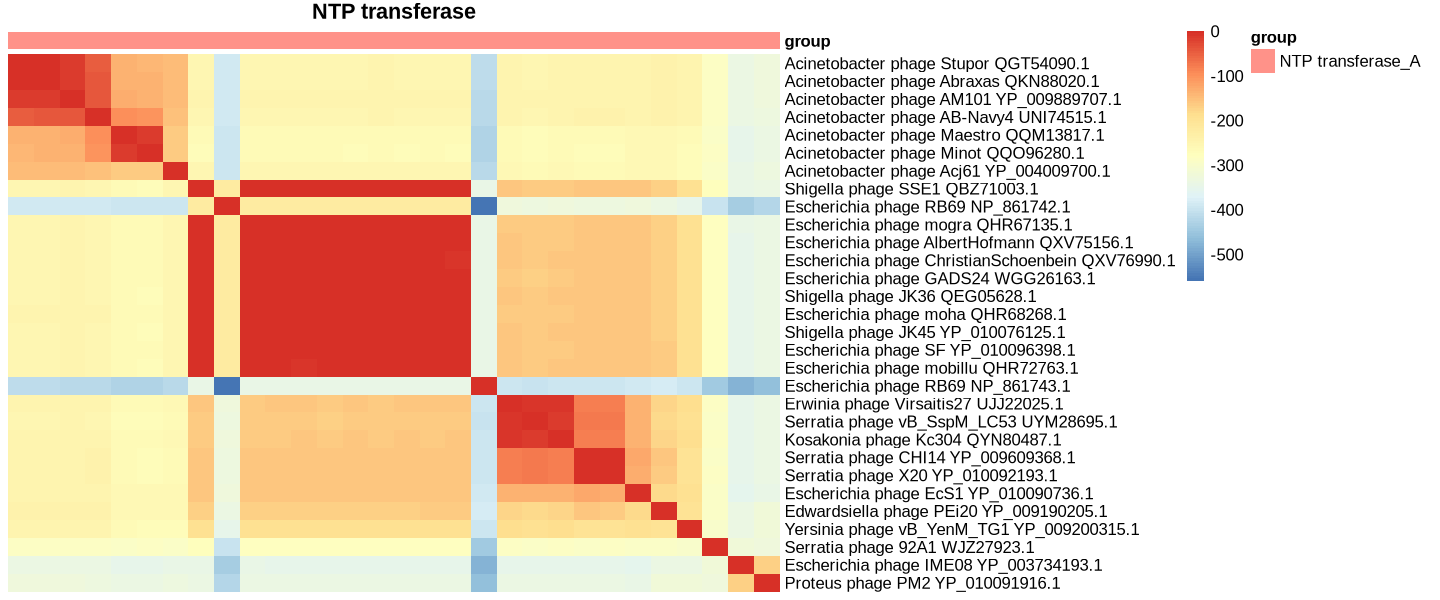

use default substitution matrix


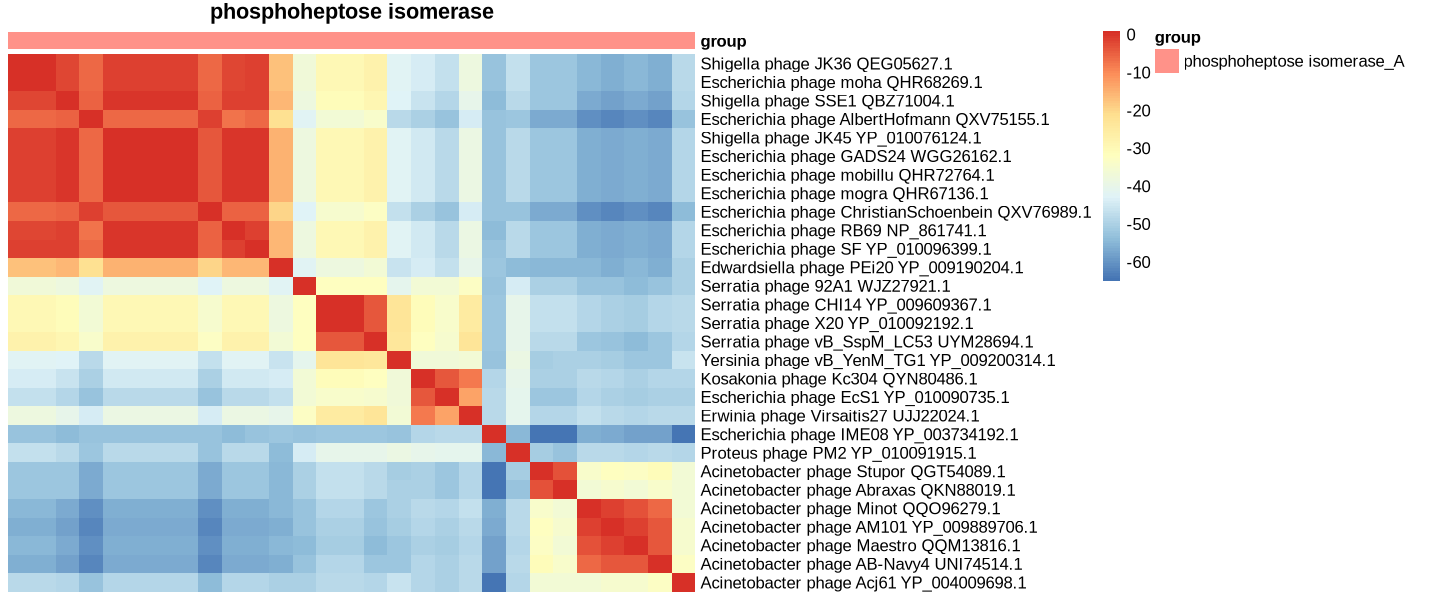

use default substitution matrix


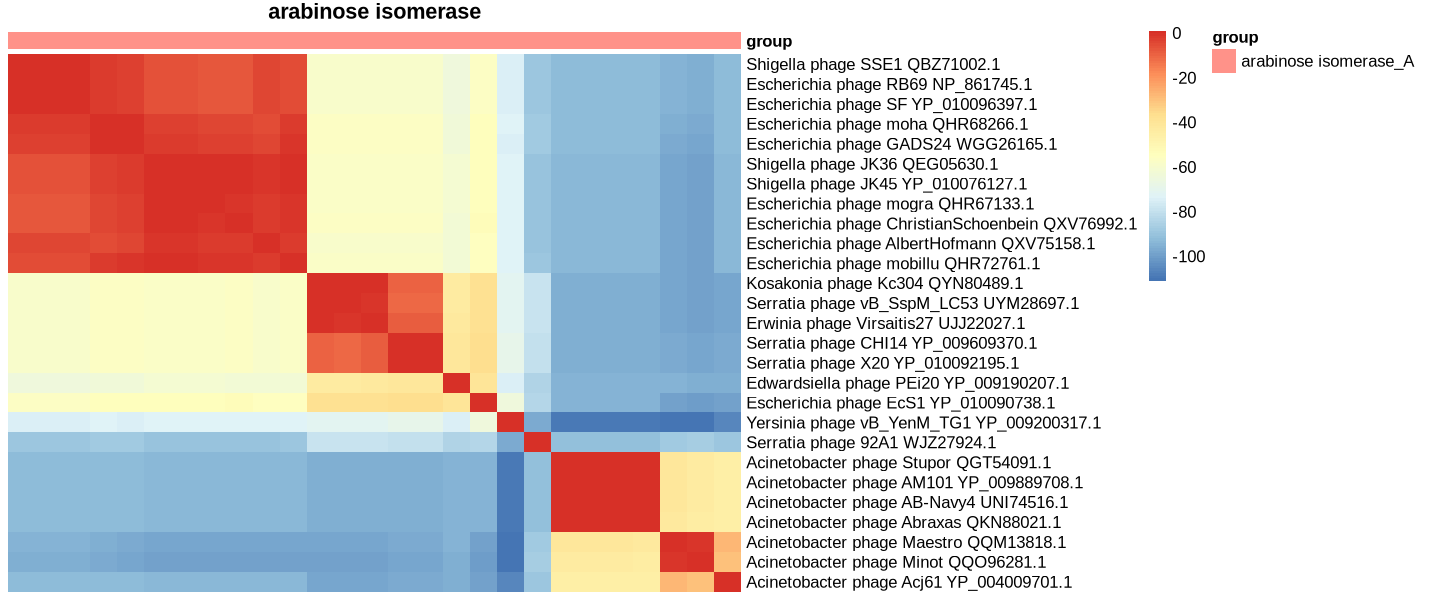

use default substitution matrix


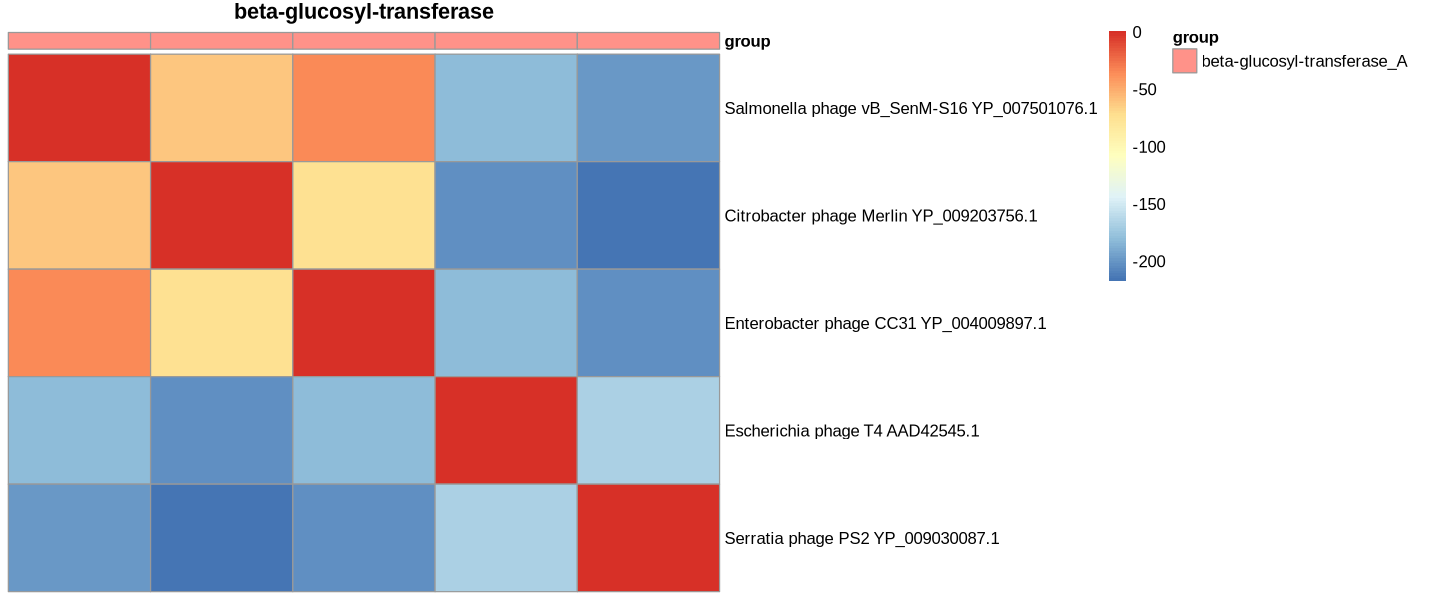

use default substitution matrix


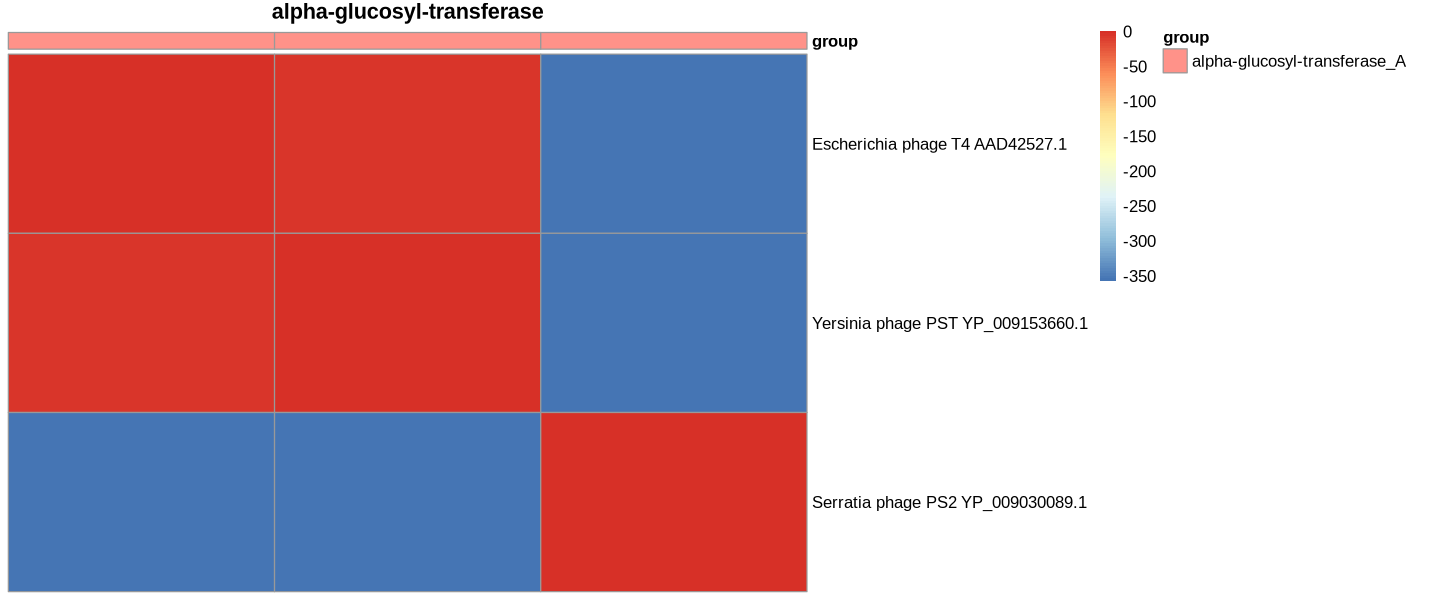

use default substitution matrix


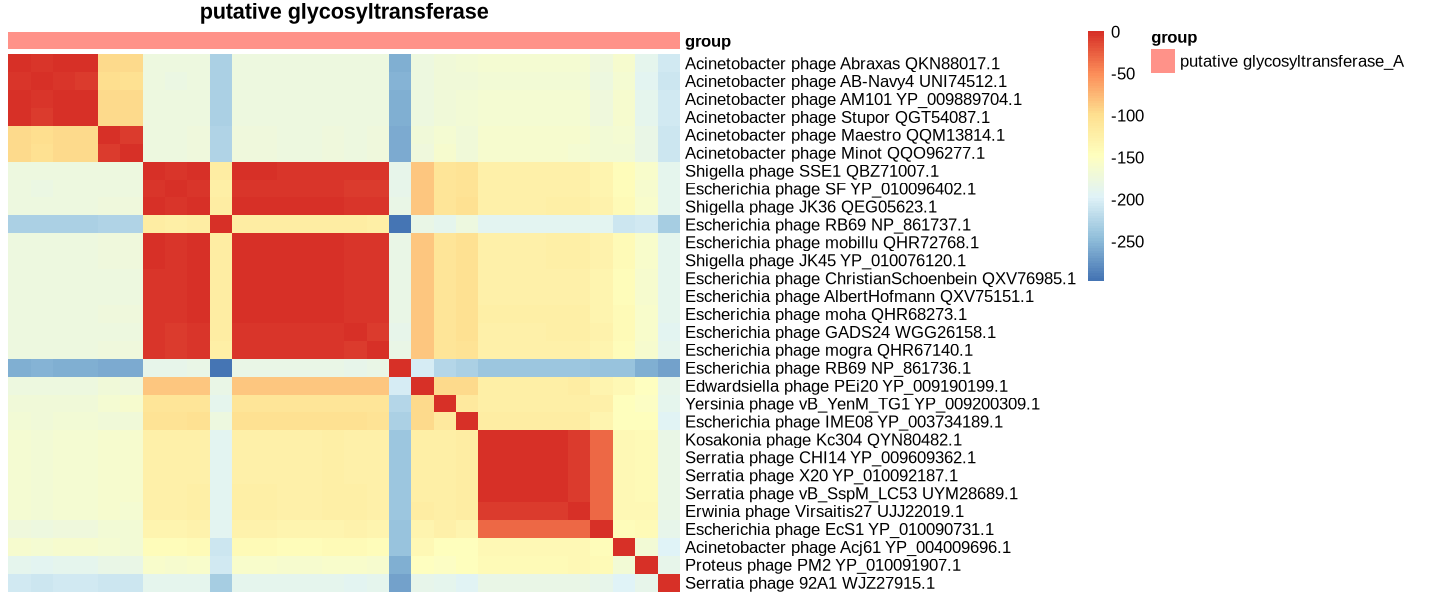

use default substitution matrix


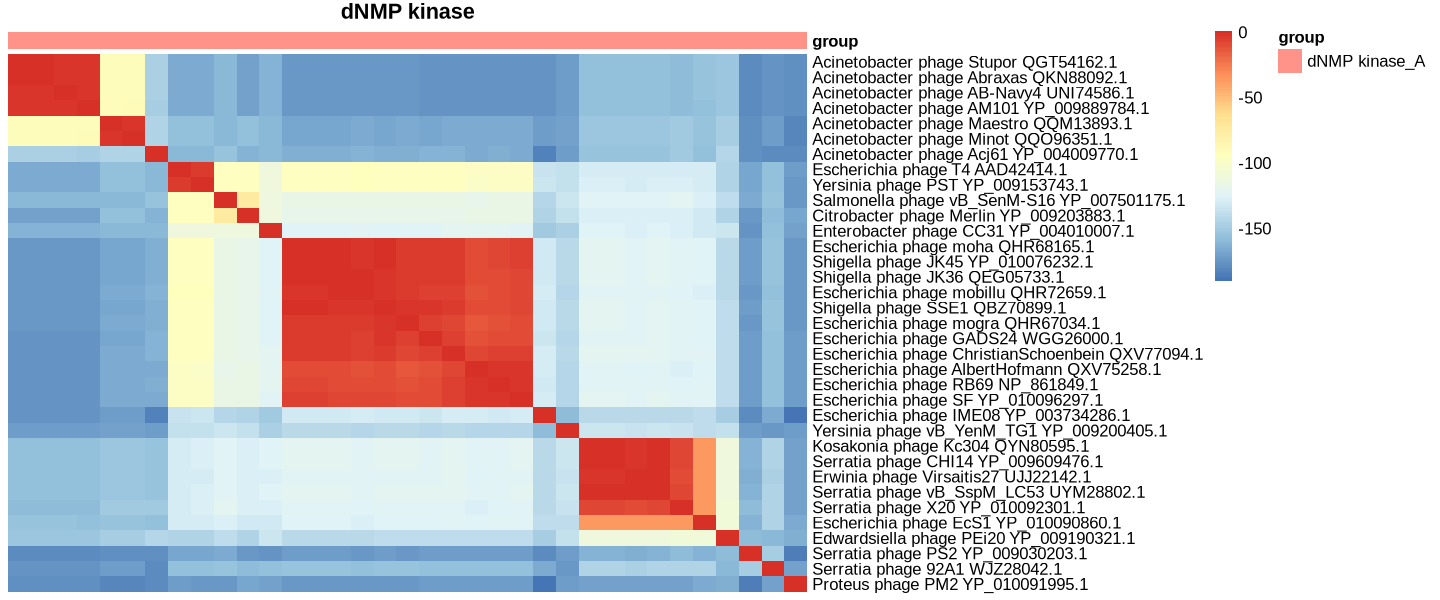

use default substitution matrix


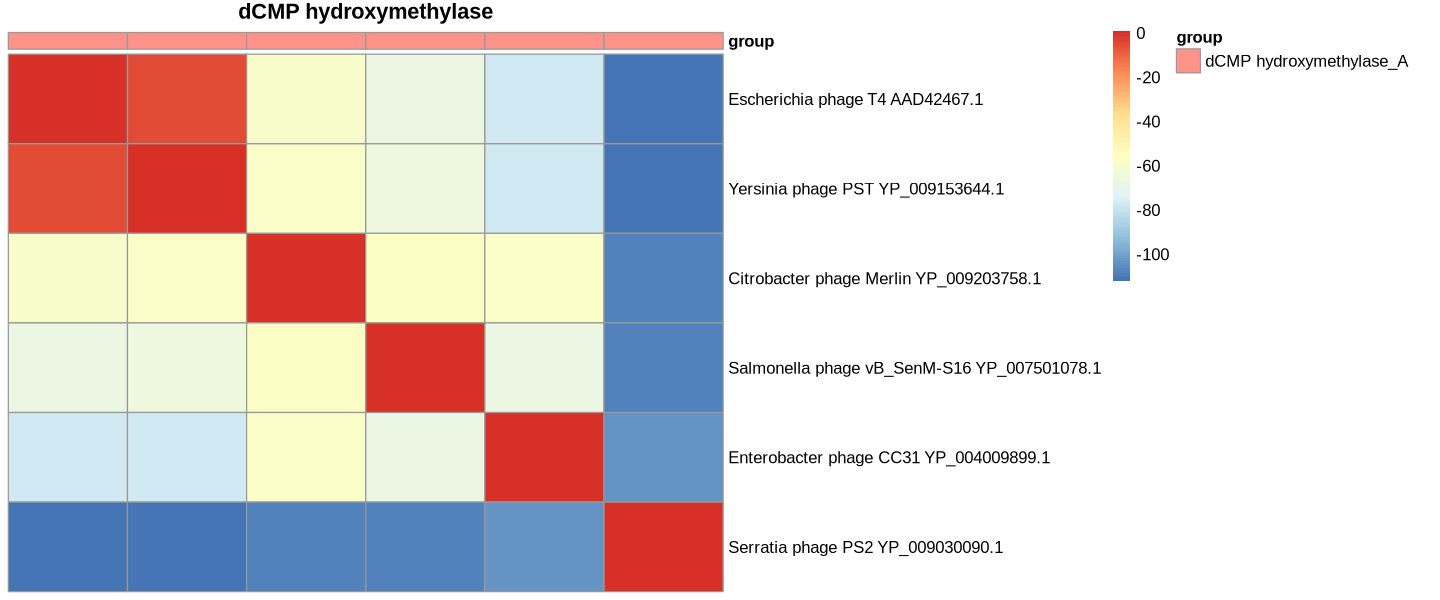

use default substitution matrix


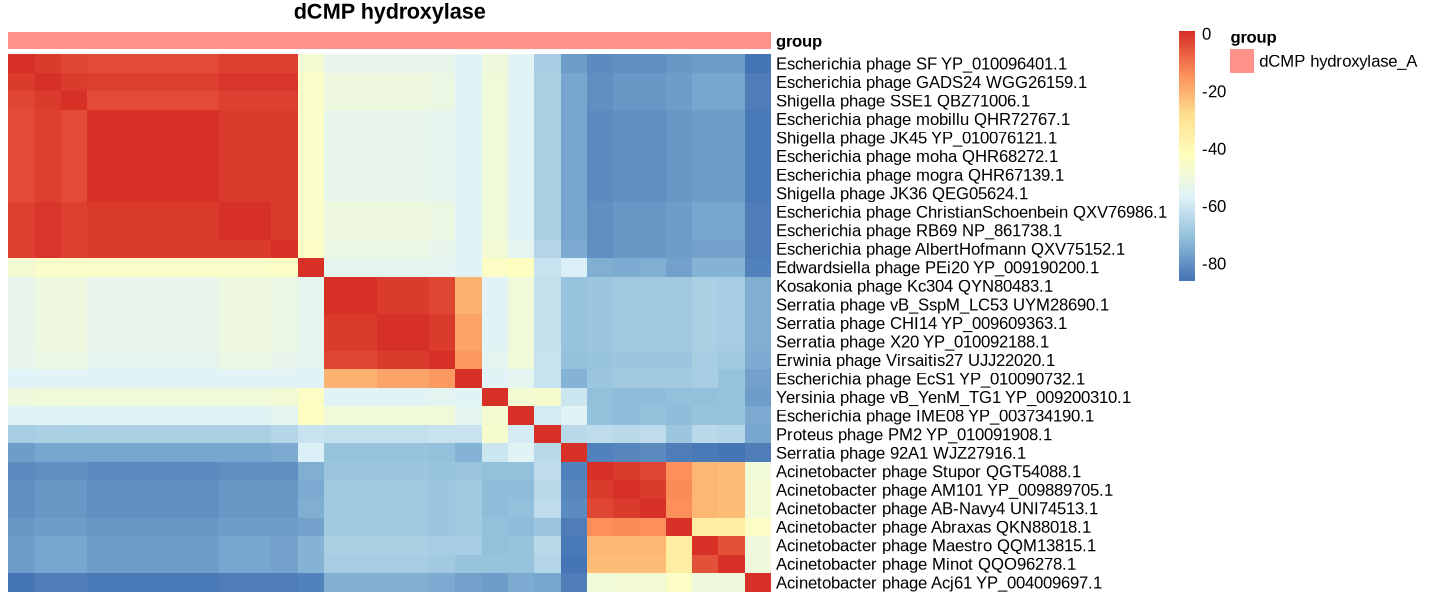

use default substitution matrix


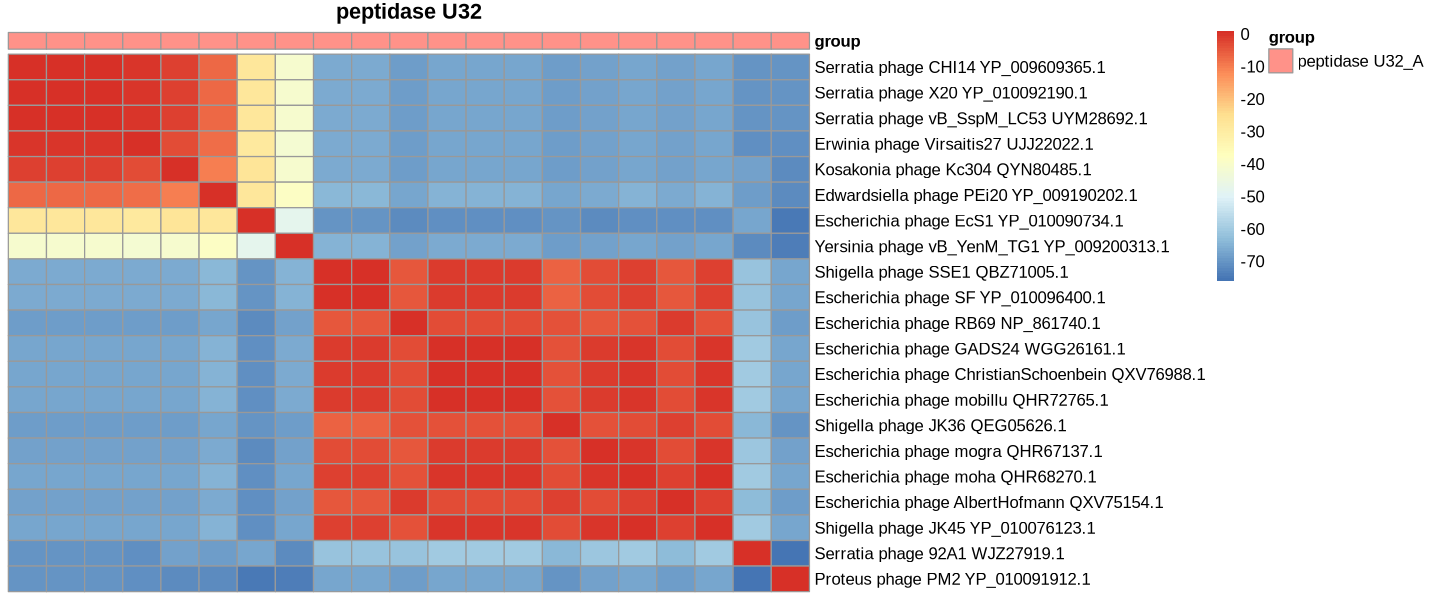

use default substitution matrix


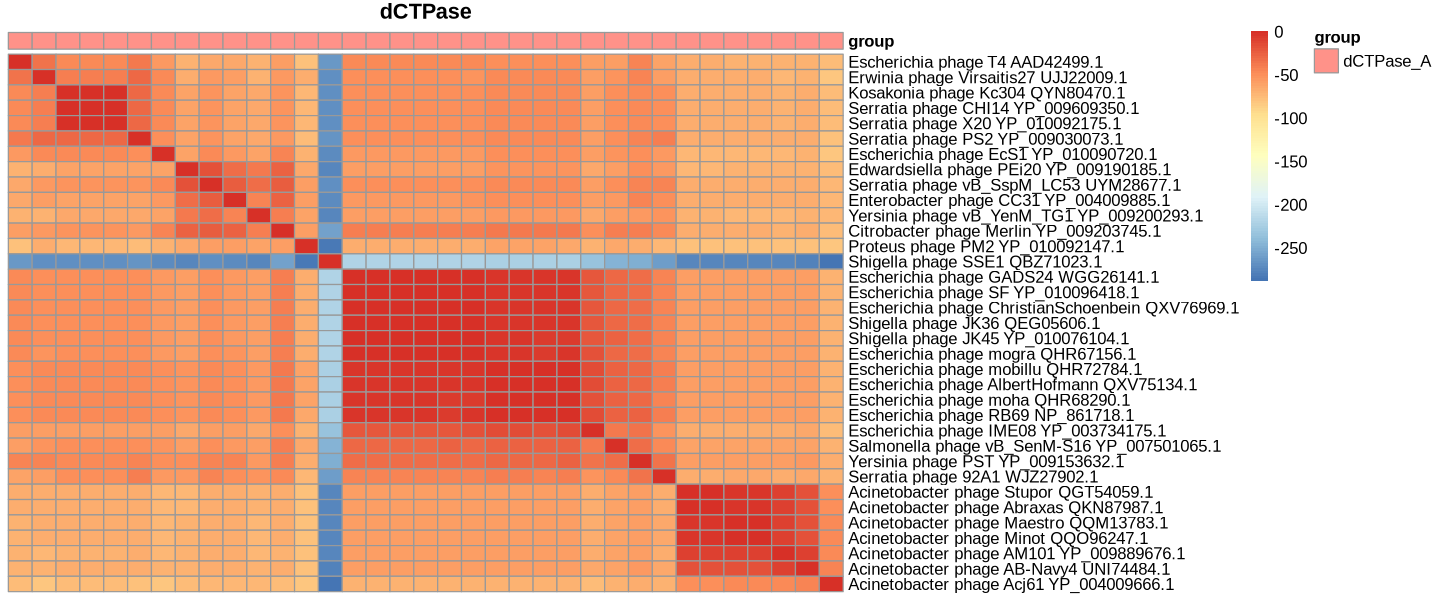

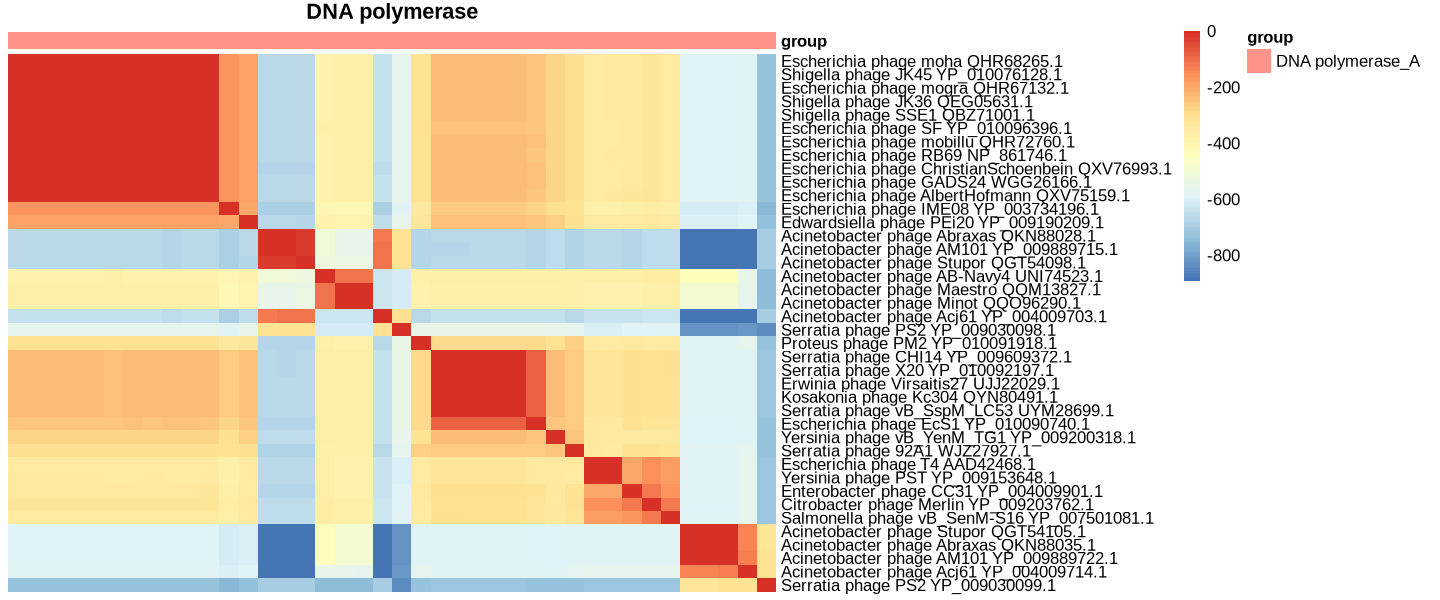

In [10]:
# Prepare protein profiles
options(repr.plot.width=12, repr.plot.height=5)

## Variables
dist_threshold <- 1000
data$key <- paste(data$Name, data$Gene.CDS.Protein.FASTA.Accession)

## Set up ann_level_2
data$ann_level_2 <- 'Other'

## Fetch genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Iterate over genes
for (i in genes) {
    index <- which(data$annotation == i)

    if (length(index) < 2) {
        data$ann_level_2[index] <- i
        next
    }
    
    ## MSA
    seq <- AAStringSet(data$protein_seq[index])
    names(seq) <- data$key[index]
    result <- msa(seq)
    result
    
    ## Distance matrix
    dist <- as.matrix(dist.gene(as.AAbin(result)))

    ## Split alignment to homogeneous groups
    x <- dist < dist_threshold
    x <- apply(x, 1, which, simplify = FALSE)
    x <- lapply(x, paste0, collapse='-')
    x <- unlist(x)
    lookup <- LETTERS[1:length(unique(x))]
    names(lookup) <- unique(x)

    ## Annotate groups
    cann <- data.frame(
        row.names = rownames(dist),
        group = paste(i, lookup[x], sep = '_')
    )

    ## Transfer annotation
    index <- match(rownames(cann), data$key)
    data$ann_level_2[index] <- cann$group
    
    ## Plot
    pheatmap(1-dist, 
             cluster_cols = FALSE, cluster_rows = FALSE,
             annotation_col = cann, show_colnames=FALSE,
             show_rownames = TRUE, labels_row = result@unmasked@ranges@NAMES, fontsize=10, main=i
            )
}

In [11]:
index <- str_detect(unique(data$ann_level_2),'B')
if (!any(index)) {
    message('No group has been split (no group B present). Removing _A...')
    data$ann_level_2 <- str_remove(data$ann_level_2, '_A')
}

No group has been split (no group B present). Removing _A...



In [12]:
# Convert ann_level to factor
data$ann_level_2 <- factor(data$ann_level_2, unique(data$ann_level_2[order(data$annotation, decreasing = FALSE)]))
levels(data$ann_level_2)

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

In [28]:
# Clean IMGVR protein fasta

## Load CHUNK 4
start <- Sys.time()
file <- '../data_copied-from-HCS/genome_databases/IMG_VR_2022-12-19_7/protein_parts/some_proteins.faa_04'
faa <- readLines(file)
stop <- Sys.time()
stop - start

## Select and replace '-'
start <- Sys.time()

### Select
index <- which(str_detect(faa, '-') & !str_detect(faa, '^>'))
length(index)

### Replace
faa[index] <- str_remove(faa[index], '-')

stop <- Sys.time()
stop - start

## Write file
newfile <- '../data_copied-from-HCS/genome_databases/IMG_VR_2022-12-19_7/protein_parts/clean_proteins.faa_04'
writeLines(faa, newfile)

Time difference of 1.527102 mins

[1] 42

Time difference of 40.73615 secs

In [16]:
# Re-combine IMGVR protein fasta
imgvr_faa <- 'analysis/prediction_imgvr/all_proteins.faa'
if (!file.exists(imgvr_faa)) {
    # Concat FAA parts
    imgvr_faa_parts <- paste0('../data_copied-from-HCS/genome_databases/IMG_VR_2022-12-19_7/protein_parts/', c('some_proteins.faa_00','some_proteins.faa_01','some_proteins.faa_02','some_proteins.faa_03','clean_proteins.faa_04'), collapse = ' ')
    sys_call <- paste('cat', imgvr_faa_parts, ' > ', imgvr_faa)
    message(sys_call)
    system(sys_call, intern=TRUE)
}

[1] TRUE

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 43 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 21 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


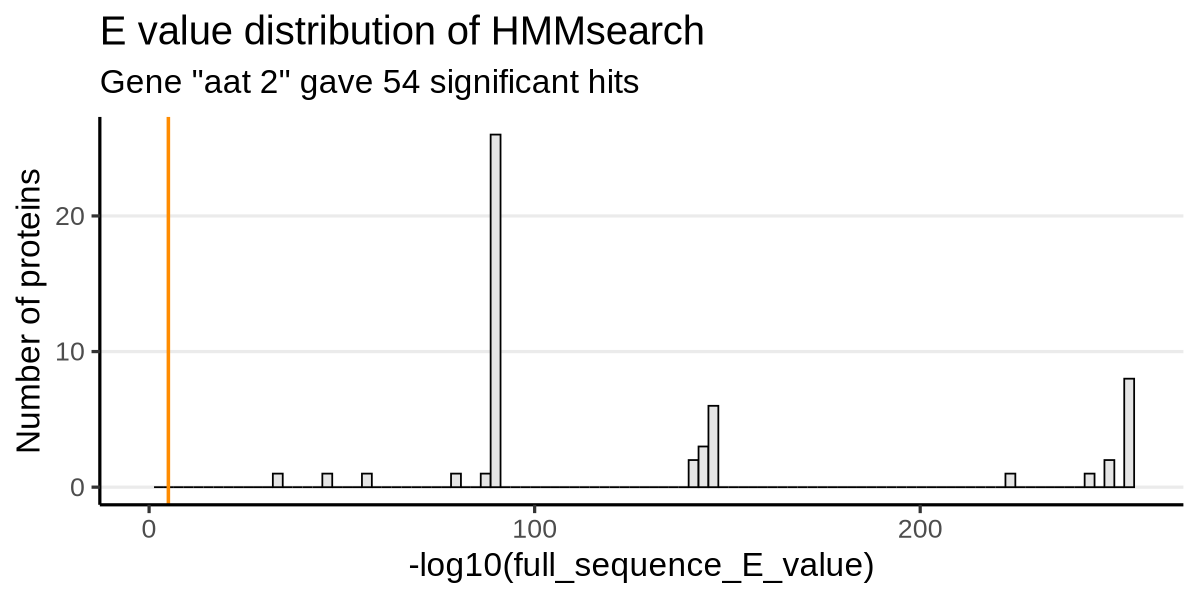

Warning message:
“Removed 180 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


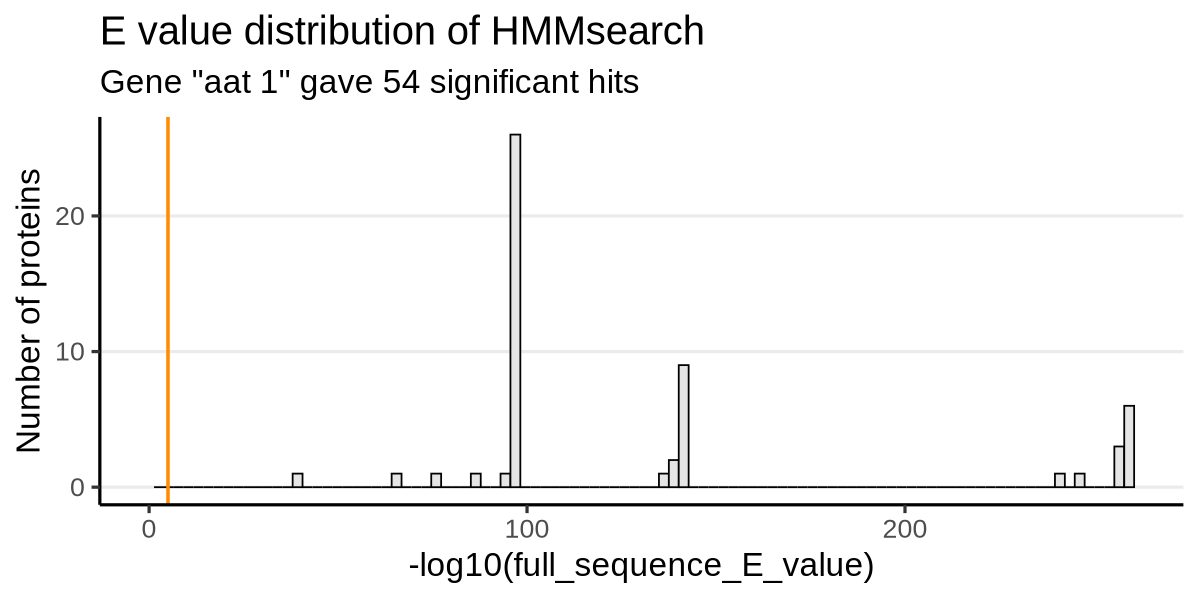

Warning message:
“Removed 5567 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


In [ ]:
# Predict annotations on IMGVR
options(repr.plot.width=10, repr.plot.height=5)

genes <- levels(data$ann_level_2)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Check spelling
all(genes %in% levels(data$ann_level_2))

## Iterate annotation over genes
pred <- list()
for (gene in genes) {
    pred[[gene]] <- annotate_gene_by_hmm_profile(
        data, annotation = 'ann_level_2', gene = gene, 
        search_db = imgvr_faa, n_cores = 8, 
        e_value_treshold = 1e-5, dir = 'analysis/prediction_imgvr/'
    )
    pred[[gene]]$annotation <- gene
}

Warning message:
“Removed 251 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_bar()`).”


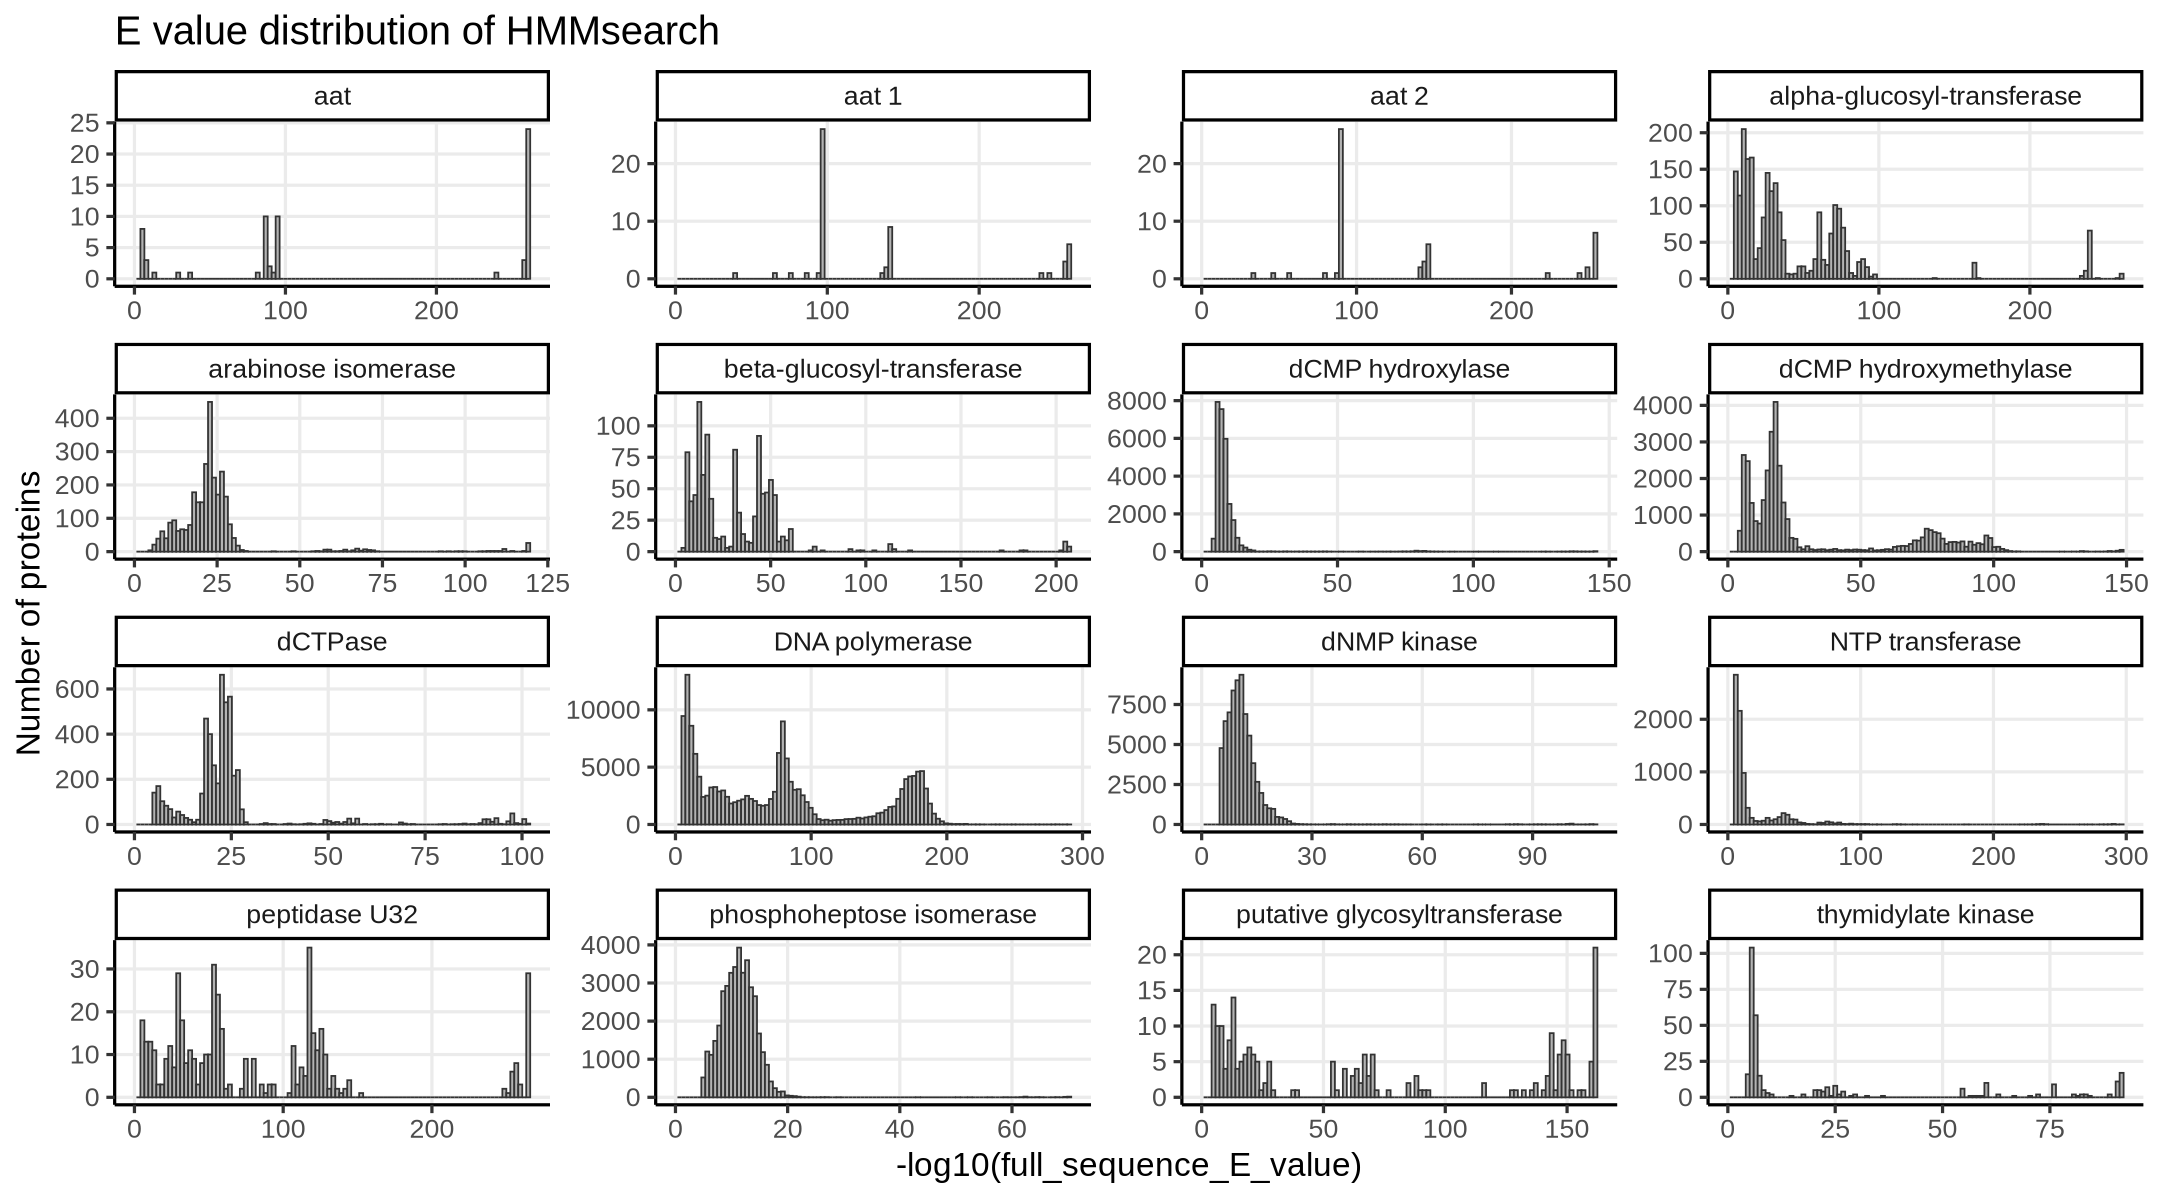

In [18]:
# Histograms of E-values
options(repr.plot.width=18, repr.plot.height=10)

## Format result
result <- do.call('rbind', pred)

## Plot
ggplot(result, aes(-log10(full_sequence_E_value))) +
  geom_histogram(bins = 100, fill='grey70', col='grey20') +
  facet_wrap(~annotation, scales = 'free') +
      scale_x_continuous(limits = c(0, NA)) +
      theme_classic(20) +
      theme(
          panel.grid.major = element_line()
      ) +
      labs(y = 'Number of proteins', title = 'E value distribution of HMMsearch')

In [19]:
## Pool
result <- do.call('rbind', pred) %>% select(Sequence, annotation, full_sequence_E_value)
result <- result[!duplicated(result), ]
result <- pivot_wider(result, names_from = Sequence, values_from = full_sequence_E_value, values_fill = 1)
result <- result %>% as.data.frame()
row.names(result) <- result$annotation
result <- result[,-1]
result[result == 0] <- 1e-300

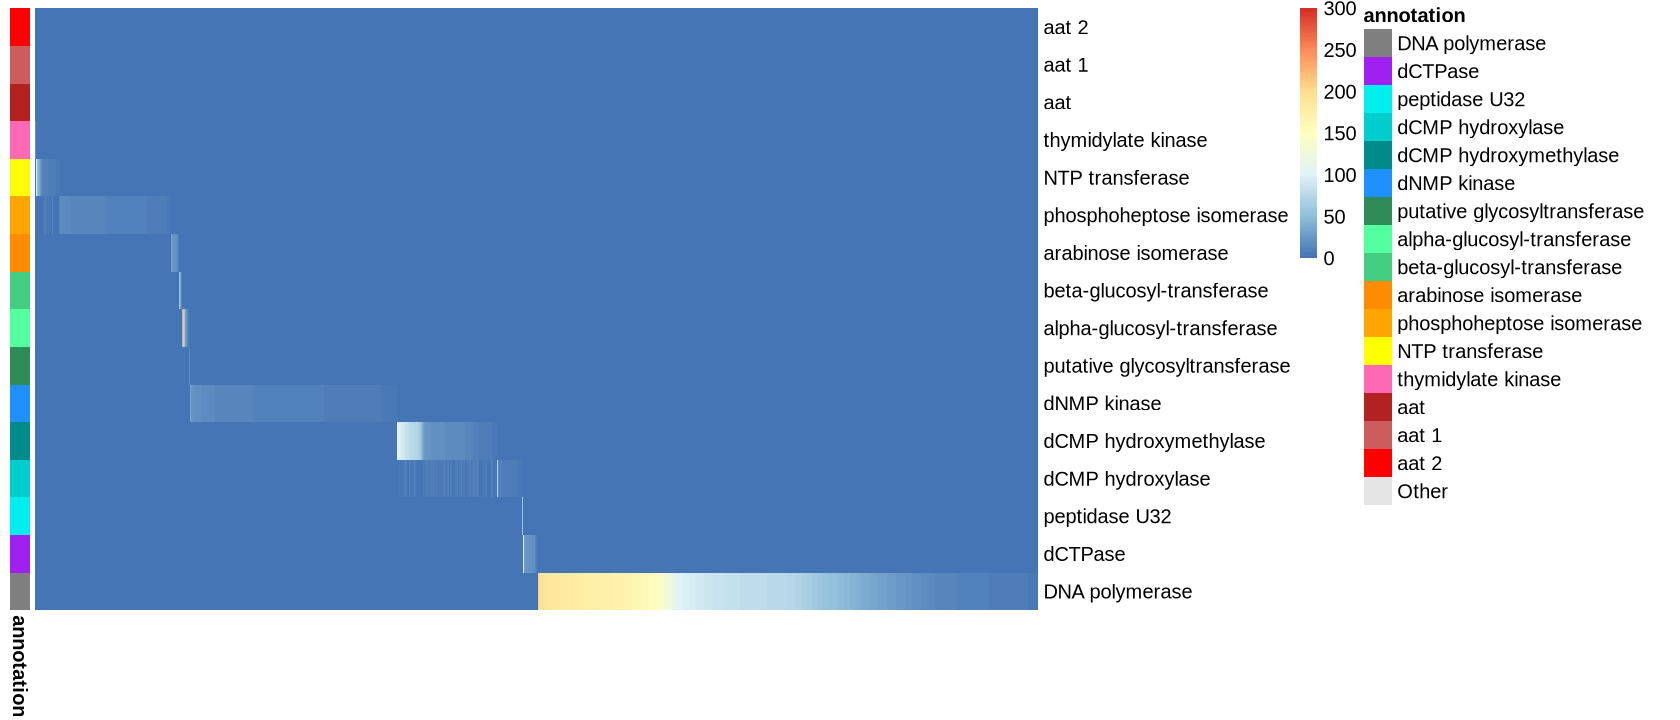

In [21]:
options(repr.plot.width=14, repr.plot.height=6)

## Row annotation
rann <- data.frame(
    row.names = rownames(result),
    annotation = str_split(rownames(result), '_', simplify=TRUE)[,1]
)

## Plot
p1 <- pheatmap(
    -log10(result), 
    cluster_cols = FALSE, cluster_rows = FALSE,
    annotation_row = rann, annotation_colors = cols,
    show_colnames=FALSE,
    fontsize=12
)

## Save
fn <- paste0(out_path,'heatmap_imgvr-hmmsearch','.png')
ggsave(fn, p1, width = 14, height = 6, bg='white')

In [31]:
## Vote
lookup <- character(length = ncol(result))
for (n in 1:ncol(result)) {
    v <- result[,n]
    names(v) <- str_split(rownames(result), '_', simplify = TRUE)[,1]
    n_min <- min(v)
    name <- unique(names(which(v == min(v))))
    if (length(name) > 1) {
        name <- paste(name, collapse='/')
    }
    lookup[[n]] <- name
}
names(lookup) <- colnames(result)

ERROR: Error: object 'features' not found


In [56]:
features <- data.frame(
    'gene' = lookup,
    'seqid' = names(lookup)
)
features$UVIG <- str_split(features$seqid, '\\|', simplify=TRUE)[, 1]
head(features)

,gene,seqid,UVIG
,<chr>,<chr>,<chr>
IMGVR_UViG_2974608002_000001|2974608002|2974608071,aat 2,IMGVR_UViG_2974608002_000001|2974608002|2974608071,IMGVR_UViG_2974608002_000001
IMGVR_UViG_2974608265_000001|2974608265|2974608333,aat 2,IMGVR_UViG_2974608265_000001|2974608265|2974608333,IMGVR_UViG_2974608265_000001
IMGVR_UViG_2974609052_000001|2974609052|2974609122,aat 2,IMGVR_UViG_2974609052_000001|2974609052|2974609122,IMGVR_UViG_2974609052_000001
IMGVR_UViG_2974614076_000001|2974614076|2974614284,aat 2,IMGVR_UViG_2974614076_000001|2974614076|2974614284,IMGVR_UViG_2974614076_000001
IMGVR_UViG_2974582188_000001|2974582188|2974582261,aat 2,IMGVR_UViG_2974582188_000001|2974582188|2974582261,IMGVR_UViG_2974582188_000001
IMGVR_UViG_2974609316_000001|2974609316|2974609387,aat 2,IMGVR_UViG_2974609316_000001|2974609316|2974609387,IMGVR_UViG_2974609316_000001


`summarise()` has grouped output by 'UVIG'. You can override using the
`.groups` argument.


[1] FALSE

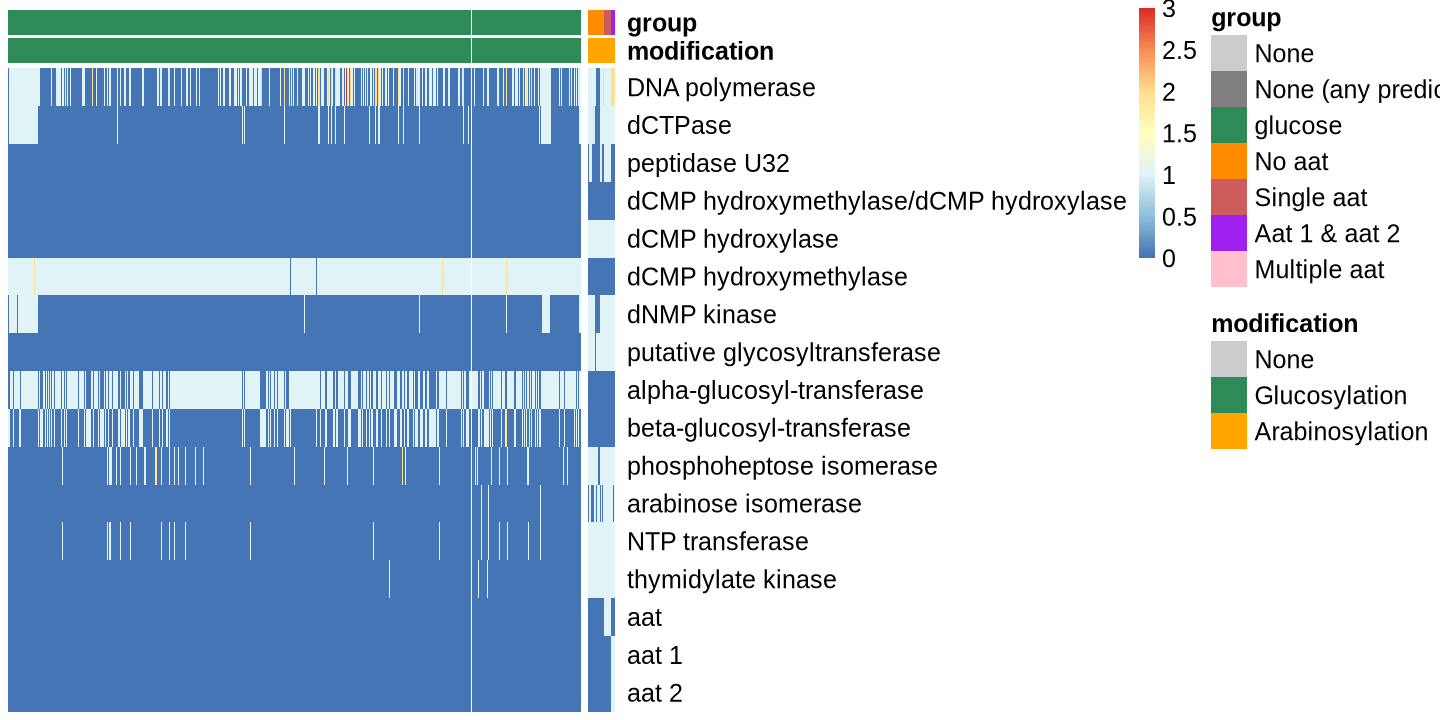

In [210]:
# Feature quantification
options(repr.plot.width=12, repr.plot.height=6)

heatmap_genes <- rev(unique(features$gene))
heatmap_genes <- heatmap_genes[!heatmap_genes %in% c('Other')]

## Summarize gene counts
df <- features %>% mutate(N=1) %>% group_by(UVIG, gene) %>% summarize(total = sum(N))

## Filter
index <- df$gene %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = UVIG, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$gene
mat <- mat[heatmap_genes, -1] %>% as.matrix()

## Set max
mat[mat >= 3] <- 3

## Binarize
bat <- mat > 0

### Row
rann <- data.frame(
    row.names = rownames(mat)
)

### Col
index <- match(colnames(mat), features$UVIG)
cann <- data.frame(
    row.names = colnames(mat)
)

##  Cluster

### Level 1
gluc_genes <- c('dCMP hydroxymethylase','alpha-glucosyl-transferase','beta-glucosyl-transferase')
ara_genes <- c('dCMP hydroxylase','putative glycosyltransferase','arabinose isomerase',
               'phosphoheptose isomerase','thymidylate kinase')
ind_gluc <- which(colSums(bat[gluc_genes,]) > 1)
ind_ara <- which(colSums(bat[ara_genes,]) > 3)
any(intersect(ind_gluc, ind_ara))

cann$modification <- 'None'
cann$modification[ind_gluc] <- 'Glucosylation'
cann$modification[ind_ara] <- 'Arabinosylation'
cann$modification <- factor(cann$modification, names(cols$modification))

### Level 2
cann$group <- 'None (any predicted)'
cann$group[cann$modification == 'Glucosylation'] <- 'glucose'
cann$group[cann$modification == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) < 1] <- 'No aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat',] == 1] <- 'Single aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat',] > 1] <- 'Multiple aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat 1',] == 1 & mat['aat 2',] == 1] <- 'Aat 1 & aat 2'
cann$group[cann$modification == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) > 2] <- 'Multiple aat'
cann$group <- factor(cann$group, rev(names(cols$group)))

# Add modification to report
index_predict <- match(rownames(cann), imgvr_seqs$UVIG)

### Group
imgvr_seqs$group <- 'None'
imgvr_seqs$group[index_predict] <- as.character(cann$group)
imgvr_seqs$group <- factor(imgvr_seqs$group, rev(names(cols$group)))

### Modification
imgvr_seqs$modification <- 'None'
imgvr_seqs$modification[index_predict] <- as.character(cann$modification)
imgvr_seqs$modification <- factor(imgvr_seqs$modification, rev(names(cols$modification)))

## Order
mat <- mat[,order(cann$modification, cann$group, decreasing = c(FALSE, TRUE), method = 'radix')]
cann <- cann[order(cann$modification, cann$group, decreasing = c(FALSE, TRUE), method = 'radix'),]

## Subset
index <- which(cann$modification %in% c('Arabinosylation','Glucosylation'))

## Plot
p1 <- pheatmap(mat[,index], 
               cluster_rows = FALSE, cluster_cols=FALSE,
               show_colnames=FALSE, annotation_colors=cols,
               annotation_col = cann[index, ],
               fontsize = 15,
               gaps_col             = head(as.numeric(cumsum((table(cann$modification[index])[table(cann$modification[index]) > 0])), -1))
              )

## Save
fn <- paste0(out_path,'heatmap_imgvr-quantification','.png')
ggsave(fn, p1, width = 11, height = 6, bg='white')

In [211]:
## Quantify
dim(mat)
length(unique(features$gene))
ncol(mat) / length(unique(features$gene))
table(imgvr_seqs$group)
table(imgvr_seqs$modification)

[1]     17 314068

[1] 17

[1] 18474.59


        Multiple aat        Aat 1 & aat 2           Single aat 
                   2                   11                   25 
              No aat              glucose None (any predicted) 
                  50                 1856               312124 
                None 
            15363555 


Arabinosylation   Glucosylation            None 
             88            1856        15675679 

Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_col()`).”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_col()`).”


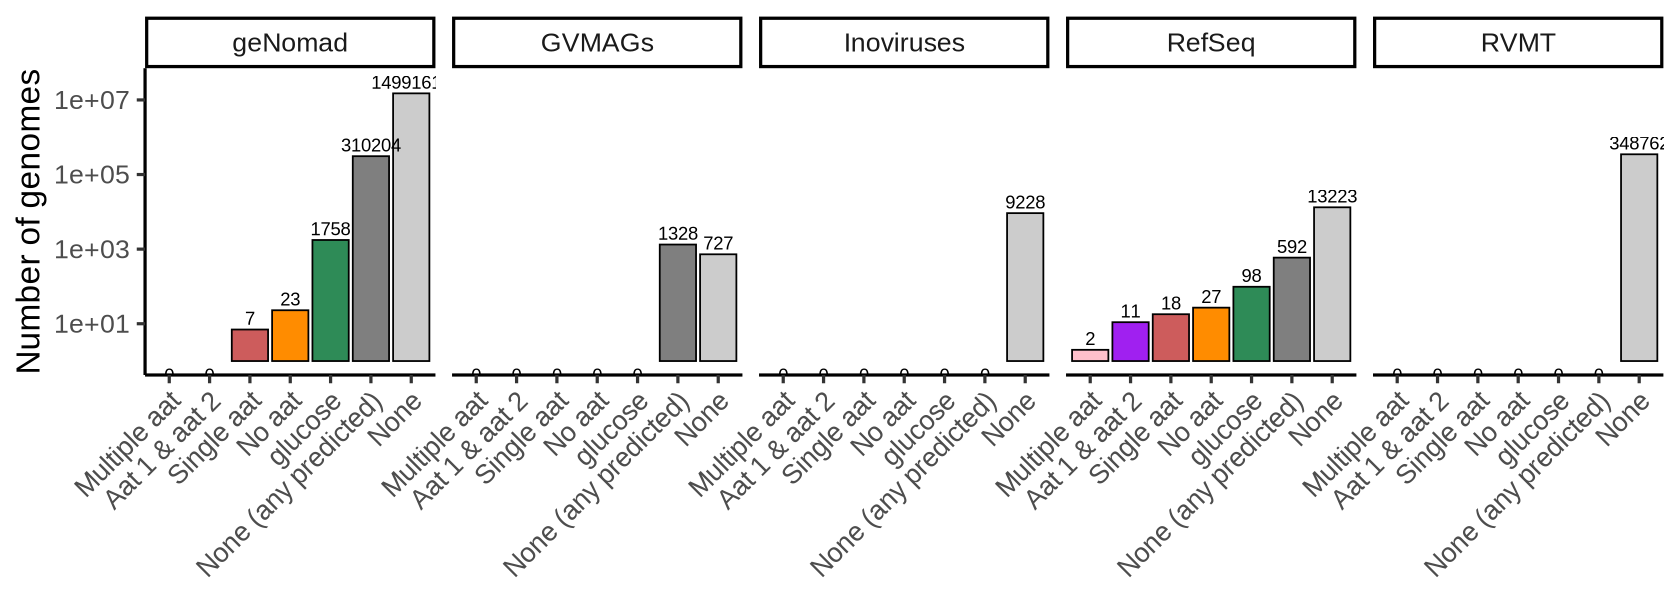

In [218]:
# Visualize groups
options(repr.plot.width=14, repr.plot.height=5)

## Fetch
df <- as.data.frame(table(imgvr_seqs$group))
names(df) <- c('group','freq')

df <- as.data.frame(table(imgvr_seqs$group, imgvr_seqs$`Sequence origin (doi)`))
names(df) <- c('group','origin','freq')
df$origin <- str_split(df$origin, ' ', simplify=TRUE)[,1]

## Order
df <- df[order(df$freq, decreasing = TRUE), ]
#df$group <- factor(df$group, unique(df$group))

## Plot
p2 <- ggplot(df, aes(group, freq, fill=group, label=freq)) +
  geom_col(position = 'stack', col='black') +
  geom_text(aes(y = freq*2)) +
  facet_wrap(~origin, nrow=1) +
  scale_fill_manual(values = cols$group) +
  scale_y_continuous(trans='log10') +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(y='Number of genomes',x=NULL,fill='Group')
p2

## Save
fn <- paste0(out_path,'barplot_imgvr-quantification','.png')
ggsave(fn, p2, width = 14, height = 5, bg='white')

In [103]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pheatmap_1.0.12     ape_5.8-1           msa_1.38.0         
 [4] Biostrings_2.74.0   GenomeInfoDb_1.42.0 XVector_0.46.0     
 [7] IRanges_2.40.0      S4Vectors_0.44.0    BiocGenerics_0.52.0
[10] ggtree_3.14.0       gggenes_0.5.1       cowplot_1.1.3      
